<img src="https://github.com/FarzadNekouee/YOLOv8_Traffic_Density_Estimation/blob/master/images/cover_image.png?raw=true" width="2400">

In [1]:
# Install YOLOv8
!pip install -q ultralytics

In [2]:
import os
import random
from glob import glob

# Set your dataset base directory
base_dir = "/kaggle/input/top-view-vehicle-detection-image-dataset/Vehicle_Detection_Image_Dataset"

# Get all image paths from train and valid folders
train_images = glob(os.path.join(base_dir, "train/images", "*.jpg"))
valid_images = glob(os.path.join(base_dir, "valid/images", "*.jpg"))

# Combine and shuffle images
all_images = train_images + valid_images
random.shuffle(all_images)

# Create dummy routes with 5 images each
num_routes = 3
images_per_route = 5
dummy_routes = {}

for i in range(num_routes):
    route_name = f"Route_{i+1}"
    dummy_routes[route_name] = all_images[i * images_per_route:(i + 1) * images_per_route]

# Print route-to-images mapping
for route, imgs in dummy_routes.items():
    print(f"{route} has {len(imgs)} images:")
    for img in imgs:
        print(f"  - {img}")


Route_1 has 5 images:
  - /kaggle/input/top-view-vehicle-detection-image-dataset/Vehicle_Detection_Image_Dataset/train/images/12_mp4-7_jpg.rf.3772fccf9706393c58387ed585727446.jpg
  - /kaggle/input/top-view-vehicle-detection-image-dataset/Vehicle_Detection_Image_Dataset/train/images/14_mp4-18_jpg.rf.de728b4158742cd5145f798bb8f28f1f.jpg
  - /kaggle/input/top-view-vehicle-detection-image-dataset/Vehicle_Detection_Image_Dataset/train/images/5_mp4-23_jpg.rf.1af6945901aadab59e9ee210b568c1cb.jpg
  - /kaggle/input/top-view-vehicle-detection-image-dataset/Vehicle_Detection_Image_Dataset/train/images/6_mp4-32_jpg.rf.2fbf5f14e51e9a234d170de78381cfbb.jpg
  - /kaggle/input/top-view-vehicle-detection-image-dataset/Vehicle_Detection_Image_Dataset/train/images/test_mp4-4_jpg.rf.a4ab418c6cdcc81f49484a8aa098b691.jpg
Route_2 has 5 images:
  - /kaggle/input/top-view-vehicle-detection-image-dataset/Vehicle_Detection_Image_Dataset/train/images/11_mp4-14_jpg.rf.0d47483007a70d056747d619748e0e0a.jpg
  - /kaggl

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Required libraries
import os
import cv2
from glob import glob
from collections import Counter
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Load YOLOv8 model
model = YOLO('yolov8n.pt')

# # Set image folder paths
# base_dir = "/kaggle/input/top-view-vehicle-detection-image-dataset/Vehicle_Detection_Image_Dataset"
# train_imgs = glob(os.path.join(base_dir, "train/images", "*.jpg"))
# valid_imgs = glob(os.path.join(base_dir, "valid/images", "*.jpg"))
# all_imgs = train_imgs + valid_imgs

# Analyze class frequencies
class_counter = Counter()

for img_path in all_images:
    try:
        results = model(img_path, imgsz=640, conf=0.5)
        detections = results[0].boxes.cls.cpu().numpy()
        class_counter.update(map(int, detections))
    except:
        print(f"Error processing image: {img_path}")

# Print class frequencies
print("\n--- YOLO Class Frequencies ---")
for cls_id, count in class_counter.items():
    print(f"Class {cls_id}: {count} detections")

# Normalize and recommend weights (0.0 to 5.0 scale)
max_count = max(class_counter.values()) if class_counter else 1
recommended_weights = {cls_id: round(5.0 * (count / max_count), 2) for cls_id, count in class_counter.items()}

print("\n--- Recommended Risk Weights ---")
for cls_id, weight in recommended_weights.items():
    print(f"Class {cls_id}: Weight = {weight}")



image 1/1 /kaggle/input/top-view-vehicle-detection-image-dataset/Vehicle_Detection_Image_Dataset/train/images/12_mp4-7_jpg.rf.3772fccf9706393c58387ed585727446.jpg: 640x640 1 car, 10.0ms
Speed: 5.5ms preprocess, 10.0ms inference, 128.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /kaggle/input/top-view-vehicle-detection-image-dataset/Vehicle_Detection_Image_Dataset/train/images/14_mp4-18_jpg.rf.de728b4158742cd5145f798bb8f28f1f.jpg: 640x640 4 cars, 5.3ms
Speed: 1.4ms preprocess, 5.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /kaggle/input/top-view-vehicle-detection-image-dataset/Vehicle_Detection_Image_Dataset/train/images/5_mp4-23_jpg.rf.1af6945901aadab59e9ee210b568c1cb.jpg: 640x640 1 person, 17 cars, 5.0ms
Speed: 1.2ms preprocess, 5.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /kaggle/input/top-view-vehicle-detection-image-dataset/Vehicle_Detection_Image_Dataset/train/images/6_mp4-32_jpg.rf.2fbf5f14e

In [4]:
# Assuming you've already run the auto-analysis and now have `recommended_weights`

# Sample fallback if you want to test manually
# recommended_weights = {
#     0: 4.5,  # pedestrian
#     1: 3.0,  # bicycle
#     2: 2.0,  # car
#     3: 3.2,  # motorcycle
#     5: 3.8,  # bus
#     7: 3.6   # truck
# }

from collections import defaultdict
from ultralytics import YOLO

# Load YOLO model
model = YOLO('yolov8n.pt')

# Set congestion-related classes
vehicle_classes = [2, 3, 5, 7]  # car, motorcycle, bus, truck

# Function to compute scores
def get_scores_dynamic(model, image_paths_by_route, risk_weights):
    scores = {}

    for route_name, image_paths in image_paths_by_route.items():
        total_vehicles = 0
        total_risk = 0.0

        for img_path in image_paths:
            results = model(img_path, imgsz=640, conf=0.5)
            detections = results[0].boxes.cls.cpu().numpy()

            for cls_id in detections:
                cls_id = int(cls_id)
                if cls_id in vehicle_classes:
                    total_vehicles += 1
                if cls_id in risk_weights:
                    total_risk += risk_weights[cls_id]

        scores[route_name] = {
            'congestion_score': total_vehicles,
            'risk_score': round(total_risk, 2)
        }

    return scores

# Example:
# image_paths_by_route = {
#     'Route_1': ['/path/to/img1.jpg', '/path/to/img2.jpg'],
#     'Route_2': ['/path/to/img3.jpg', '/path/to/img4.jpg'],
# }
# scores = get_scores_dynamic(model, image_paths_by_route, recommended_weights)
# for route, data in scores.items():
#     print(f"{route} → Congestion: {data['congestion_score']}, Risk: {data['risk_score']}")


In [5]:
scores=get_scores_dynamic(model, dummy_routes, recommended_weights)
# Display the scores
for route, score in scores.items():
    print(f"{route}:Score = {score}")


image 1/1 /kaggle/input/top-view-vehicle-detection-image-dataset/Vehicle_Detection_Image_Dataset/train/images/12_mp4-7_jpg.rf.3772fccf9706393c58387ed585727446.jpg: 640x640 1 car, 5.0ms
Speed: 1.4ms preprocess, 5.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /kaggle/input/top-view-vehicle-detection-image-dataset/Vehicle_Detection_Image_Dataset/train/images/14_mp4-18_jpg.rf.de728b4158742cd5145f798bb8f28f1f.jpg: 640x640 4 cars, 4.7ms
Speed: 1.3ms preprocess, 4.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /kaggle/input/top-view-vehicle-detection-image-dataset/Vehicle_Detection_Image_Dataset/train/images/5_mp4-23_jpg.rf.1af6945901aadab59e9ee210b568c1cb.jpg: 640x640 1 person, 17 cars, 4.8ms
Speed: 1.2ms preprocess, 4.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /kaggle/input/top-view-vehicle-detection-image-dataset/Vehicle_Detection_Image_Dataset/train/images/6_mp4-32_jpg.rf.2fbf5f14e51e9

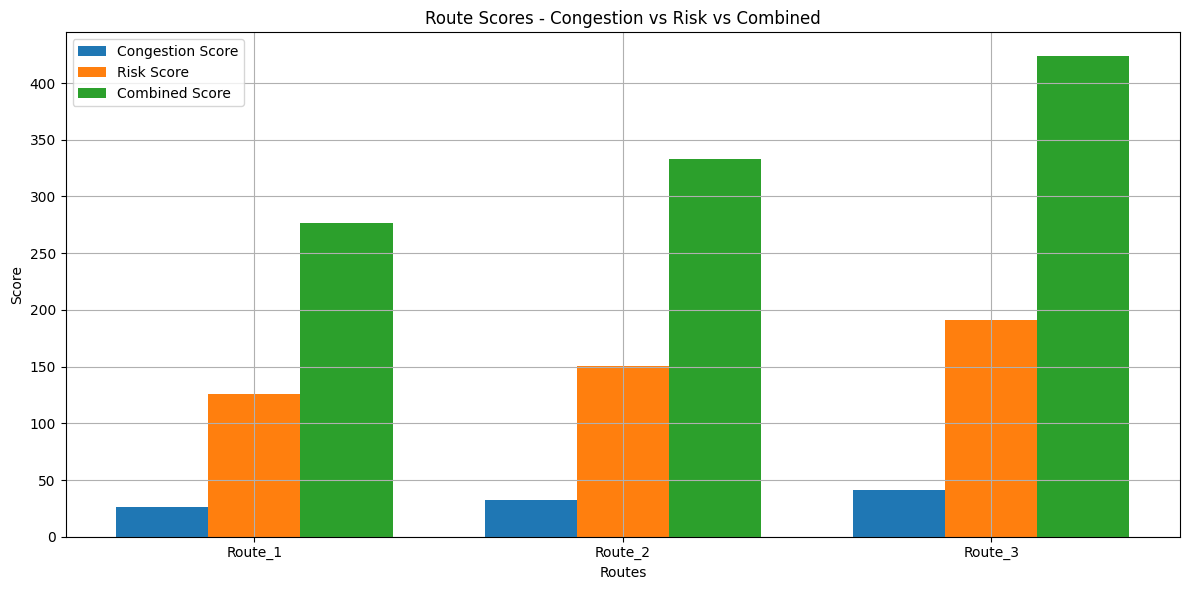


--- Adjusted A* Edge Weights ---
('A', 'B'): 37.68
('A', 'C'): 45.33
('B', 'C'): 47.35


In [6]:
import matplotlib.pyplot as plt

# # Sample output from get_scores_dynamic()
# scores = {
#     'Route_1': {'congestion_score': 15, 'risk_score': 20},
#     'Route_2': {'congestion_score': 30, 'risk_score': 5},
#     'Route_3': {'congestion_score': 25, 'risk_score': 15}
# }

# STEP 1: Combine scores using a weighted sum
alpha = 1.0  # congestion weight
beta = 2.0   # risk weight

combined_scores = {}
for route, data in scores.items():
    combined = alpha * data['congestion_score'] + beta * data['risk_score']
    combined_scores[route] = round(combined, 2)

# STEP 2: Visualize results
routes = list(combined_scores.keys())
congestion_values = [scores[r]['congestion_score'] for r in routes]
risk_values = [scores[r]['risk_score'] for r in routes]
combined_values = [combined_scores[r] for r in routes]

x = range(len(routes))
bar_width = 0.25

plt.figure(figsize=(12, 6))
plt.bar(x, congestion_values, width=bar_width, label='Congestion Score')
plt.bar([i + bar_width for i in x], risk_values, width=bar_width, label='Risk Score')
plt.bar([i + 2*bar_width for i in x], combined_values, width=bar_width, label='Combined Score')
plt.xlabel("Routes")
plt.ylabel("Score")
plt.title("Route Scores - Congestion vs Risk vs Combined")
plt.xticks([i + bar_width for i in x], routes)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# STEP 3: Adjusted A* Edge Weights
k = 0.1  # multiplier for combined score influence

# Original edge weights
edge_weights = {
    ('A', 'B'): 10,
    ('A', 'C'): 12,
    ('B', 'C'): 5
}

# Map routes to edges
route_map = {
    'Route_1': ('A', 'B'),
    'Route_2': ('A', 'C'),
    'Route_3': ('B', 'C')
}

# Compute adjusted edge weights
adjusted_edge_weights = {}
for route, (src, dst) in route_map.items():
    base_weight = edge_weights.get((src, dst), 0)
    adjusted_weight = base_weight + k * combined_scores[route]
    adjusted_edge_weights[(src, dst)] = round(adjusted_weight, 2)

# Print final adjusted edge weights
print("\n--- Adjusted A* Edge Weights ---")
for edge, weight in adjusted_edge_weights.items():
    print(f"{edge}: {weight}")


# LLM

In [16]:

!pip install -U -q "google-generativeai>=0.7.2" # Install the Python SDK


In [17]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("geminiAPI")

In [18]:
import os
import google.generativeai as genai

api_key = os.getenv("GOOGLE_API_KEY")
genai.configure(api_key=secret_value_0)

In [25]:
import google.generativeai as genai
import json

# 1. Set your Gemini API key securely
# genai.configure(api_key="YOUR_GEMINI_API_KEY")

# 2. LLM Query Function (strict and reliable)
def query_llm_for_route_context(route_id, score_data):
    prompt = f"""
You are a traffic analysis assistant. Here's route {route_id}:
- Congestion Score: {score_data['congestion_score']}
- Risk Score: {score_data['risk_score']}

Only return a valid JSON object with no extra commentary But give details not just 1 line but follow format. Format:
{{
  "risk_addon": float, 
  "reason": str
}}

Example:
{{
  "risk_addon": 6.5,
  "reason": "Heavy congestion and frequent pedestrian activity."
}}
"""

    model = genai.GenerativeModel(model_name="gemini-1.5-pro")
    response = model.generate_content(prompt)
    response_text = response.text.strip()

    try:
        # Clean up formatting if it's wrapped in markdown
        if "```json" in response_text:
            response_text = response_text.split("```json")[-1].split("```")[0].strip()
        elif "```" in response_text:
            response_text = response_text.split("```")[-1].strip()
        
        result = json.loads(response_text)
    except Exception as e:
        print(f"⚠️ Failed to parse LLM response for {route_id}:\n{response_text}\nError: {e}")
        result = {"risk_addon": 0, "reason": "Failed to parse Gemini response."}

    return result

# 3. Scoring Function with LLM + YOLO integration
def rank_routes_from_scores(scores, alpha=1.0, beta=2.0, gamma=1.0):
    final_scores = {}

    for route, score_data in scores.items():
        llm_info = query_llm_for_route_context(route, score_data)

        final = (
            alpha * score_data['congestion_score'] +
            beta * score_data['risk_score'] +
            gamma * llm_info['risk_addon']
        )

        final_scores[route] = {
            "adjusted_score": round(final, 2),
            "llm_reason": llm_info["reason"]
        }

    return final_scores


In [26]:
ranked_scores = rank_routes_from_scores(scores)
print(json.dumps(ranked_scores, indent=2))

{
  "Route_1": {
    "adjusted_score": 277.84,
    "llm_reason": "Moderate congestion score indicates slightly elevated risk."
  },
  "Route_2": {
    "adjusted_score": 348.32,
    "llm_reason": "Moderate congestion (congestion score 32) necessitates a moderate risk adder."
  },
  "Route_3": {
    "adjusted_score": 435.52,
    "llm_reason": "Moderate congestion combined with a significantly elevated risk score suggests potential hazards such as road closures, accidents, or ongoing construction."
  }
}


In [27]:
# Example original edge weights from API or map
edge_weights = {
    ('A', 'B'): 10,
    ('A', 'C'): 12,
    ('B', 'C'): 5
}

# Map of routes to their respective edges
route_to_edge_map = {
    'Route_1': ('A', 'B'),
    'Route_2': ('A', 'C'),
    'Route_3': ('B', 'C')
}

# Assume this is the final_scores output from rank_routes_from_scores()
# final_scores = {
#     'Route_1': {'adjusted_score': 76.4, 'llm_reason': "..."},
#     'Route_2': {'adjusted_score': 51.2, 'llm_reason': "..."},
#     'Route_3': {'adjusted_score': 63.7, 'llm_reason': "..."}
# }

final_scores = rank_routes_from_scores(scores)

# Weight modifier (how much adjusted score influences the edge cost)
k = 0.1

# Generate updated edge weights using adjusted_score
adjusted_edge_weights = {}

for route_id, (src, dst) in route_to_edge_map.items():
    base = edge_weights.get((src, dst), 0)
    addon = k * final_scores[route_id]['adjusted_score']
    adjusted_edge_weights[(src, dst)] = round(base + addon, 2)

# Print updated edge weights (for A* or routing logic)
print("\n--- Updated A* Edge Weights with LLM Influence ---")
for edge, weight in adjusted_edge_weights.items():
    print(f"{edge}: {weight}")



--- Updated A* Edge Weights with LLM Influence ---
('A', 'B'): 37.93
('A', 'C'): 46.83
('B', 'C'): 48.55
